# Treatment of uncomplicated UTIs in primary care

### Obtaining data from BigQuery

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline

In [2]:
projectid = "ebmdatalab"
#obtain long term trends data for trimethoprim and nitrofurantoin
lt_overall_df = pd.read_gbq("""
SELECT
year, 
  SUM(CASE
      WHEN chemical = 'Trimethoprim' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN chemical = 'Nitrofurantoin' THEN items
      ELSE 0 END) AS nitrofurantoin_items
FROM
  `ebmdatalab.richard.trimethoprim_pca`
GROUP BY
year
  """, projectid, dialect='standard')

Requesting query... ok.
Job ID: job_agVchW2f6EIxLxMrL4DnJHM2BJ3L
Query running...
Query done.
Processed: 1.2 KB
Standard price: $0.00 USD

Retrieving results...
Got 20 rows.

Total time taken 3.66 s.
Finished at 2018-03-26 11:30:45.


In [3]:
#obtain overall data for all CCG prescribing for trimethoprim
overall_df = pd.read_gbq("""
SELECT
  FORMAT_TIMESTAMP("%B %Y", trimethoprim.month) as month_string,
  trimethoprim.month as period,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
ccg.org_type = 'CCG'
and   trimethoprim.month >='2011-01-01 00:00:00'
GROUP BY
  period, month_string
ORDER BY
  period
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_Ev_8TmUGt1EC7f7NXN0DYmo4m_py
Query running...
  Elapsed 11.01 s. Waiting...
Query done.
Processed: 148.2 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 11.72 s.
Got 83 rows.

Total time taken 11.73 s.
Finished at 2018-03-26 11:31:19.


In [4]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.pct,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and trimethoprim.month  >='2011-01-01 00:00:00'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_eDsftNWWwjak1UZ3TKxIzsfRpMAv
Query running...
Query done.
Processed: 148.2 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 7.64 s.
Got 17316 rows.

Total time taken 7.97 s.
Finished at 2018-03-26 11:31:48.


In [5]:
#obtain overall data for prescribing for trimethoprim at practice level where practices with list size of => 1000
practice_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.practice,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
  ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.practice_statistics_all_years AS listsize
ON
  trimethoprim.practice=listsize.practice
AND   
  trimethoprim.month=listsize.month
WHERE
  listsize.total_list_size >=1000
  and trimethoprim.month >='2011-01-01 00:00:00'
GROUP BY
  period,
  practice
ORDER BY
  period,
  practice
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_vJDOv4nr-nRYOvROPHakXmJKVsFy
Query running...
  Elapsed 11.03 s. Waiting...
Query done.
Processed: 178.2 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 9% done. Elapsed 20.55 s.
  Got page: 2; 18% done. Elapsed 26.31 s.
  Got page: 3; 27% done. Elapsed 31.79 s.
  Got page: 4; 36% done. Elapsed 37.44 s.
  Got page: 5; 45% done. Elapsed 42.36 s.
  Got page: 6; 54% done. Elapsed 48.14 s.
  Got page: 7; 63% done. Elapsed 54.45 s.
  Got page: 8; 72% done. Elapsed 58.64 s.
  Got page: 9; 81% done. Elapsed 65.55 s.
  Got page: 10; 90% done. Elapsed 70.32 s.
  Got page: 11; 99% done. Elapsed 77.03 s.
  Got page: 12; 100% done. Elapsed 77.81 s.
Got 645524 rows.

Total time taken 99.37 s.
Finished at 2018-03-26 11:33:49.


## Create stacked bar charts

### Long-term trend bar chart

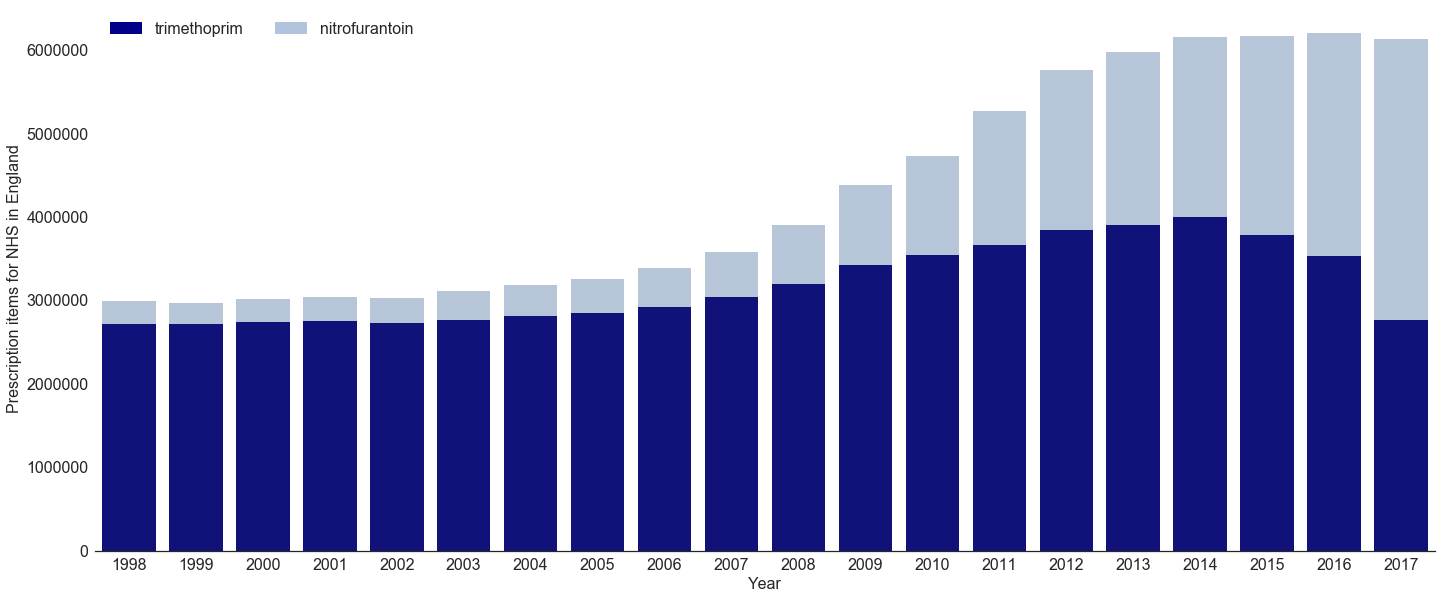

In [6]:
#Create additional columns for bar stacks
lt_overall_df['all_items']=lt_overall_df['trimethoprim_items']+lt_overall_df['nitrofurantoin_items']

#Create stacked graph in Seaborn, using overlaid plots

#setup style and size
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#plot chart
#top_plot - "all_items"  - will show "nitrofurantoin" in final plot
top_plot = sns.barplot(x="year", y="all_items",data=lt_overall_df,color = "lightsteelblue", ci=None)
#bottom_plot - "trimethoprim_items"
bottom_plot = sns.barplot(x="year", y="trimethoprim_items",data=lt_overall_df, color = "darkblue", ci=None)

#create legend
topbar = plt.Rectangle((0,0),1,1,fc="lightsteelblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='darkblue',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['trimethoprim', 'nitrofurantoin'], loc=0, ncol = 32, prop={'size':16})
l.draw_frame(False)

#format axes
sns.despine(left=True)
bottom_plot.set_ylabel("Prescription items for NHS in England")
bottom_plot.set_xlabel("Year")
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

### Monthly trend bar chart

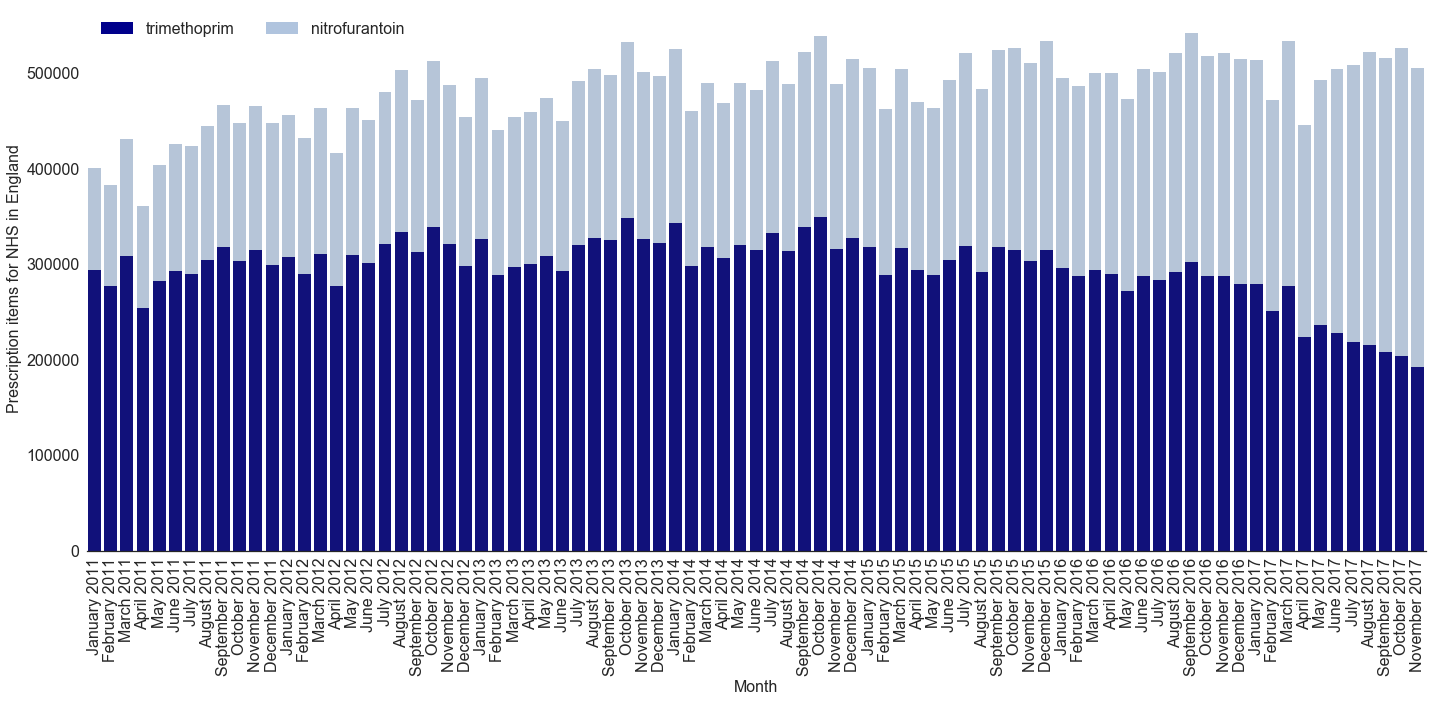

In [7]:
#Create additional columns for bar stacks
overall_df['all_items']=overall_df['trimethoprim_items']+overall_df['nitrofurantoin_items']

#Create stacked graph in Seaborn, using overlaid plots

#setup style and size
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#plot chart
#top_plot - "all_items"  - will show "nitrofurantoin" in final plot
top_plot = sns.barplot(x="month_string", y="all_items",data=overall_df,color = "lightsteelblue", ci=None)
#bottom_plot - "trimethoprim_items"
bottom_plot = sns.barplot(x="month_string", y="trimethoprim_items",data=overall_df, color = "darkblue", ci=None)

#create legend
topbar = plt.Rectangle((0,0),1,1,fc="lightsteelblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='darkblue',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['trimethoprim', 'nitrofurantoin'], loc=0, ncol = 32, prop={'size':16})
l.draw_frame(False)

#format axes
plt.xticks(rotation=90)
sns.despine(left=True)
bottom_plot.set_ylabel("Prescription items for NHS in England")
bottom_plot.set_xlabel("Month")
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

### Create timeseries for CCGs and practice deciles of percentage of pregabalin as Lyrica

In [8]:
import datetime
#create deciles for practices
x = np.arange(0.1, 1, 0.1)
practice_deciles = practice_df.groupby('period')['trimethoprim_percent'].quantile(x)
practice_deciles_df=pd.DataFrame(practice_deciles)
practice_deciles_df=practice_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
practice_deciles_df["index"] = (practice_deciles_df.level_1*10).map(int)
practice_deciles_df['period'] = practice_deciles_df['period'].astype(str)
# set format for dates:
practice_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in practice_deciles_df['period']]

#create deciles for CCGs
x = np.arange(0.1, 1, 0.1)
ccg_deciles = ccg_df.groupby('period')['trimethoprim_percent'].quantile(x)
ccg_deciles_df=pd.DataFrame(ccg_deciles)
ccg_deciles_df=ccg_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
ccg_deciles_df["index"] = (ccg_deciles_df.level_1*10).map(int)
ccg_deciles_df['period'] = ccg_deciles_df['period'].astype(str)
# set format for dates:
ccg_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in ccg_deciles_df['period']]

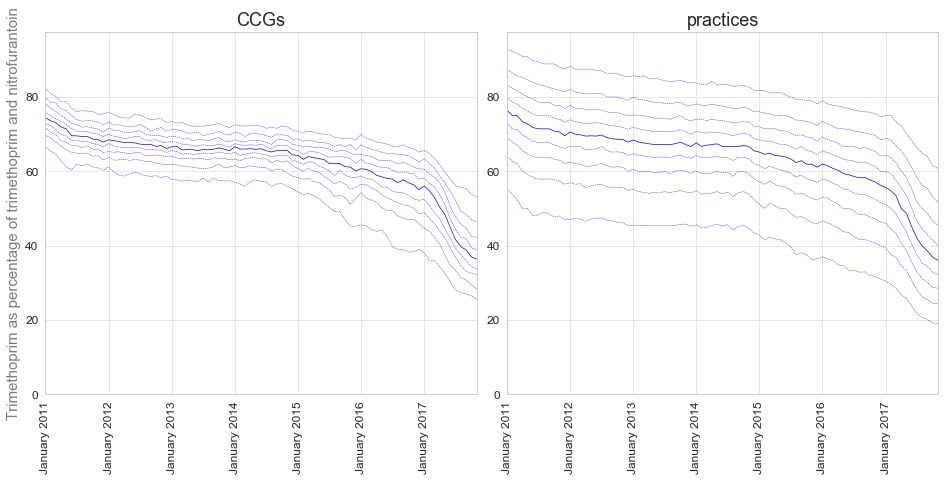

In [12]:
# Plot time series charts of deciles
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})

fig = plt.figure(figsize=(16,6.666)) 
gs = gridspec.GridSpec(1,2)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'CCGs'), (1,practice_deciles_df,0,1,'practices')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]],sharey=ax)  # position of subplot in grid using coordinates listed in s
    for decile in range(1,10):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 5:
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b-',linewidth=0.7)
        else:
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b--',linewidth=0.4)
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Trimethoprim as percentage of trimethoprim and nitrofurantoin', size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['trimethoprim_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15)
#plt.savefig('Figure X.png', format='png', dpi=300)
plt.show()

In [ ]:
#ccg_idr_df=ccg_deciles_df.pivot(index='period', columns='level_1', values='trimethoprim_percent')

In [ ]:
#ccg_idr_df = ccg_idr_df.rename(columns={0.1:"one",0.9:"nine"})

In [ ]:
#ccg_idr_df.head()

In [ ]:
#ccg_idr_df["IDR"] = ccg_idr_df['nine'] - ccg_idr_df['one']

In [ ]:
#from IPython.display import display, HTML
##pd.set_option('display.max_colwidth', -1)
#display(HTML(ccg_idr_df.to_html(header=False)))

In [13]:
ccg_idr_df=ccg_deciles_df.pivot(index='period', columns='level_1', values='trimethoprim_percent')
ccg_idr_df = ccg_idr_df.rename(columns={0.1:"one",0.9:"nine"})
ccg_idr_df["IDR"] = ccg_idr_df['nine'] - ccg_idr_df['one']
ccg_idr_df=ccg_idr_df.reset_index()


In [14]:
practice_idr_df=practice_deciles_df.pivot(index='period', columns='level_1', values='trimethoprim_percent')
practice_idr_df = practice_idr_df.rename(columns={0.1:"one",0.9:"nine"})
practice_idr_df["IDR"] = practice_idr_df['nine'] - practice_idr_df['one']
practice_idr_df=practice_idr_df.reset_index()


(0, 50)

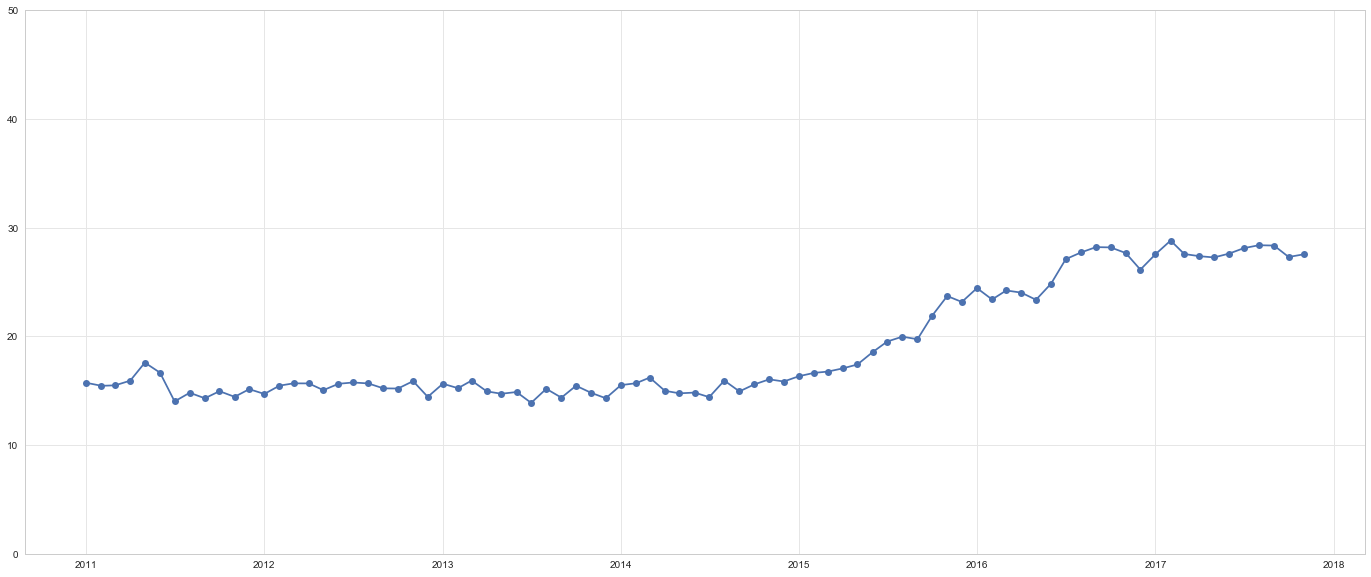

In [15]:
plt.plot_date(ccg_idr_df["period"], 100*ccg_idr_df["IDR"], linestyle= "solid")
plt.ylim(0,50)

(0, 50)

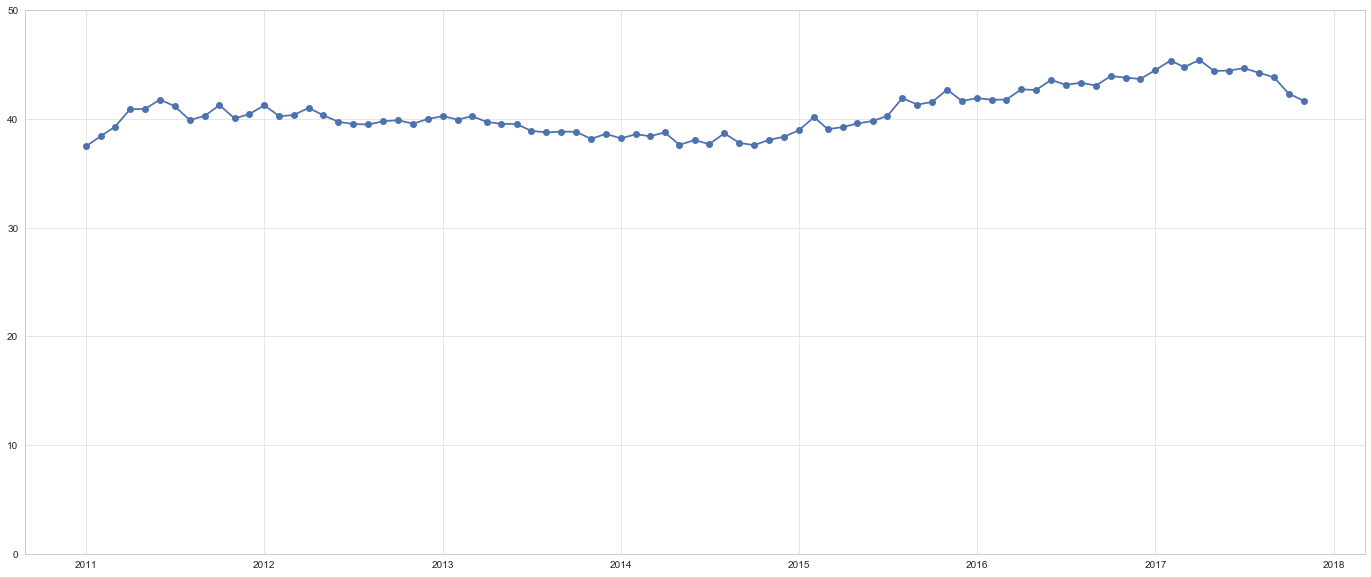

In [16]:
plt.plot_date(practice_idr_df["period"], 100*practice_idr_df["IDR"], linestyle= "solid")
plt.ylim(0,50)

In [51]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_pre_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and (trimethoprim.month >='2014-04-01 00:00:00' and trimethoprim.month <= '2014-09-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_bj9OZRqtCCCTEVlSyax8Q5s1qRbR
Query running...
Query done.
Cache hit.

Retrieving results...
Got 209 rows.

Total time taken 1.12 s.
Finished at 2018-03-26 12:12:00.


In [52]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_post_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and (trimethoprim.month >='2014-10-01 00:00:00' and trimethoprim.month <= '2015-03-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_pbktLskDp-EaCiawpnSDSJd0Z4YP
Query running...
Query done.
Cache hit.

Retrieving results...
Got 209 rows.

Total time taken 1.2 s.
Finished at 2018-03-26 12:12:23.


In [53]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_qp_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and (trimethoprim.month >='2017-04-01 00:00:00' and trimethoprim.month <= '2017-09-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_qHFlKgRQ6l0HRyM3bULLcTOKgi2U
Query running...
Query done.
Cache hit.

Retrieving results...
Got 207 rows.

Total time taken 1.02 s.
Finished at 2018-03-26 12:12:45.


In [54]:

# join to geographical data
pre_map_data = ccg_pre_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
pre_map_data = pre_map_data.merge(names[['code','name']],left_on="pct",right_on="code")
pre_map_data['name'] = pre_map_data['name'].str.upper()
pre_map_data['name'] = pre_map_data["name"].str.replace("&","AND")
pre_map_data = pre_map_data.set_index('name')
#pre_map_data= pre_map_data.rename(columns={'trimethoprim_percent':"Trimethoprim % January-June 2014"})
#map_data = map_data.round(0)
pre_map_data.head() # 207 rows

post_map_data = ccg_post_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
post_map_data = post_map_data.merge(names[['code','name']],left_on="pct",right_on="code")
post_map_data['name'] = post_map_data['name'].str.upper()
post_map_data['name'] = post_map_data["name"].str.replace("&","AND")
post_map_data = post_map_data.set_index('name')

qp_map_data = ccg_qp_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
qp_map_data = qp_map_data.merge(names[['code','name']],left_on="pct",right_on="code")
qp_map_data['name'] = qp_map_data['name'].str.upper()
qp_map_data['name'] = qp_map_data["name"].str.replace("&","AND")
qp_map_data = qp_map_data.set_index('name')
#post_map_data= post_map_data.rename(columns={'trimethoprim_percent':"Trimethoprim % June-November 2017"})
#map_data = map_data.round(0)
#post_map_data.head() # 207 rows

In [55]:
ccg_pre_df.head()

,pct,trimethoprim_percent
0,00C,0.712682
1,00D,0.679011
2,00J,0.691303
3,00K,0.681066
4,00L,0.627610


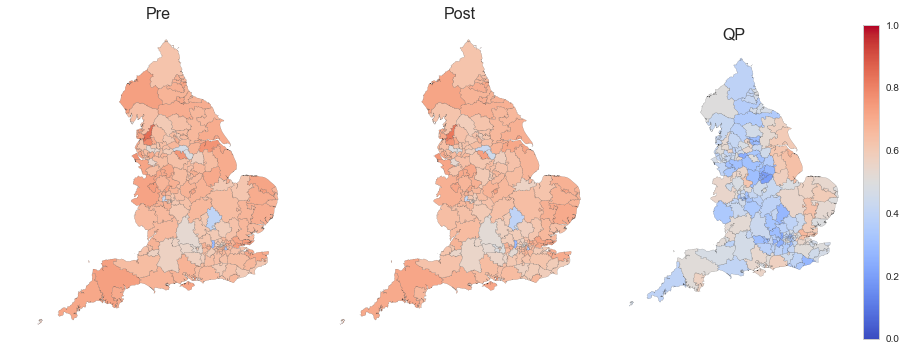

In [56]:
import geopandas as gpd
from matplotlib import verbose
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf_pre = ccgs.join(pre_map_data)
gdf_post = ccgs.join(post_map_data)
gdf_qp = ccgs.join(qp_map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s_pre = [(0,'trimethoprim_percent',0,0)]
s_post = [(1,'trimethoprim_percent',0,1)]
s_qp = [(2,'trimethoprim_percent',0,2)]

# set common value limits for colour scale
vmin, vmax = 0, 1

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(5,3)  # grid layout for subplots

for i in s_post:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_post.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=False, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("Post", size=16)
    plt.axis('off')
for i in s_pre:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_pre.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=False, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("Pre",size = 16)
    plt.axis('off')
for i in s_qp:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_qp.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("QP",size = 16)
    plt.axis('off')
plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

In [22]:
# resistance data with map

resistance_df=pd.read_csv('resistance_q3_2017.csv')


In [23]:
resistance_df.head()

,CCG,Value
0,"NHS AIREDALE, WHARFDALE AND CRAVEN CCG",30.434781
1,NHS ASHFORD CCG,20.245399
2,NHS AYLESBURY VALE CCG,27.500001
3,NHS BARKING AND DAGENHAM CCG,26.146790
4,NHS BARNET CCG,32.921812


In [24]:

names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
resistance_map_data = resistance_df(names[['CCG']],left_on="pct")
pre_map_data['name'] = pre_map_data['name'].str.upper()
pre_map_data['name'] = pre_map_data["name"].str.replace("&","AND")
pre_map_data = pre_map_data.set_index('name')
#pre_map_data= pre_map_data.rename(columns={'trimethoprim_percent':"Trimethoprim % January-June 2014"})
#map_data = map_data.round(0)
pre_map_data.head() # 207 rows

KeyError: "['CCG'] not in index"

In [ ]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
highest_10_pre_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' 
      AND (trimethoprim.pct='03C' or
trimethoprim.pct='10G' or
trimethoprim.pct='09P' or
trimethoprim.pct='09Y' or
trimethoprim.pct='04K' or
trimethoprim.pct='08G' or
trimethoprim.pct='01Y' or
trimethoprim.pct='04M' or
trimethoprim.pct='04N' or
trimethoprim.pct='04L' or
trimethoprim.pct='03X')
AND (trimethoprim.month >='2014-01-01 00:00:00' and trimethoprim.month <= '2014-06-01 00:00:00')
THEN items
        ELSE 0 END), SUM(items)) AS lowest_10_pre_precent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
(trimethoprim.pct='03H' or
trimethoprim.pct='99E' or
trimethoprim.pct='07G' or
trimethoprim.pct='03T' or
trimethoprim.pct='07K' or
trimethoprim.pct='99F' or
trimethoprim.pct='05D' or
trimethoprim.pct='03K' or
trimethoprim.pct='07N' or
trimethoprim.pct='02Y')
and (trimethoprim.month >='2014-01-01 00:00:00' and trimethoprim.month <= '2014-06-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')

In [ ]:
highest_10_pre_df.head()

In [ ]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
highest_10_post_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
(trimethoprim.pct='03H' or
trimethoprim.pct='99E' or
trimethoprim.pct='07G' or
trimethoprim.pct='03T' or
trimethoprim.pct='07K' or
trimethoprim.pct='99F' or
trimethoprim.pct='05D' or
trimethoprim.pct='03K' or
trimethoprim.pct='07N' or
trimethoprim.pct='02Y')
and (trimethoprim.month >='2017-06-01 00:00:00' and trimethoprim.month <= '2017-11-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')

In [ ]:
highest_10_post_df.head()

In [ ]:
ccg_df.head()

In [ ]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.pct,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data_highest_10 AS trimethoprim
WHERE
trimethoprim.month  >='2011-01-01 00:00:00'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')